> https://github.com/ukairia777/tensorflow-nlp-tutorial/blob/main/18.%20Fine-tuning%20BERT%20(Cls%2C%20NER%2C%20NLI)/18-4.%20kor_bert_nsmc_model_from_transformers_gpu.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **데이터셋 가져오기**

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/AIFFELTHON/AIFFELTHON_BBC/no_nan_qna_set.csv', index_col=0)
# df = pd.read_table('/content/drive/MyDrive/AIFFELTHON/AIFFELTHON_BBC/moonee_qna_set.txt', sep=',', index_col=0)
# df.head()

### **sub_type을 categorical data로**

In [ ]:
sub_type_mapping = {
    '내비게이션': 0,
    '타이어': 1,
    '라이트': 2,
    '시동': 3,
    '경고등': 4,
    '차량외부': 5,
    '차량내부': 6,
    '주행관련': 7,
    '사고조사': 8,
    '단말기': 9,
    '주유/충전카드': 10,
    '후방카메라': 11,
    '하이패스': 12,
    '차량점검': 13,
    '브레이크': 14,
    '블랙박스': 15,
    '위생문제': 16,
    '주차장': 17,
    'ADAS': 18,
    '비치품': 19,
    '충전기확인': 20
}

func = lambda x: sub_type_mapping.get(x, x)

In [ ]:
df['sub_type'] = df['sub_type'].map(func)

### **train, test set 분리**

In [ ]:
from sklearn.model_selection import train_test_split

# train_test_split
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=True, random_state=930)

In [ ]:
# drop=True 안 하면 index 열 안 사라짐
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [ ]:
train_data.sub_type.nunique(), test_data.sub_type.nunique()

(21, 21)

In [ ]:
print('훈련용 리뷰 개수 :', len(train_data)) # 훈련용 개수 출력
print('테스트용 리뷰 개수 :', len(test_data)) # 테스트 개수 출력

훈련용 리뷰 개수 : 4668
테스트용 리뷰 개수 : 1168


In [ ]:
# train_data[:5] # 상위 5개 출력

In [ ]:
# test_data[:5]

In [ ]:
train_data['inquiry'].nunique(), train_data['sub_type'].nunique()

(3922, 21)

In [ ]:
### 일부러 스킵
# train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거

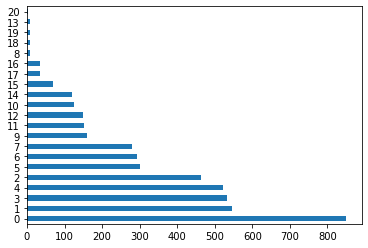

In [ ]:
train_data['sub_type'].value_counts().plot(kind='barh')

In [ ]:
print(train_data.groupby('sub_type').size().reset_index(name='count'))

    sub_type  count
0          0    849
1          1    545
2          2    464
3          3    532
4          4    521
5          5    300
6          6    293
7          7    280
8          8      9
9          9    160
10        10    125
11        11    153
12        12    150
13        13      8
14        14    121
15        15     70
16        16     34
17        17     36
18        18      8
19        19      8
20        20      2


In [ ]:
print(test_data.groupby('sub_type').size().reset_index(name='count'))

    sub_type  count
0          0    209
1          1    130
2          2    119
3          3    140
4          4    121
5          5     89
6          6     75
7          7     68
8          8      2
9          9     20
10        10     33
11        11     37
12        12     49
13        13      5
14        14     21
15        15     20
16        16     12
17        17     12
18        18      2
19        19      2
20        20      2


In [ ]:
print(train_data.isnull().values.any())

False


### **토크나이저를 이용한 정수 인코딩**
- 이미 학습해놓은 모델을 사용하다보면 (1)토크나이저, (2)모델 두 가지를 로드해야 한다.

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 13.9 MB/s 
     |████████████████████████████████| 86 kB 5.4 MB/s 
     |████████████████████████████████| 596 kB 71.2 MB/s 
     |████████████████████████████████| 6.6 MB 70.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import transformers

transformers.__version__

'4.19.2'

> https://thebook.io/080289/ch10/02/02-05/
> - `bert-base`: 영어에 사용되도록 만들어짐
> - `bert-base-uncased`: 모든 문장을 소문자로 대체
> - 한국어를 사용하기 위해선 `bert-base-multilingual-cased`를 사용하는 것이 좋다.
> - 100개 이상의 언어를 적용할 수 있는 모델


In [ ]:
# 사전 훈련된 BERT 의 토크나이저를 사용하겠다.

from transformers import BertTokenizerFast

# tokenizer = BertTokenizerFast.from_pretrained("klue/bert-base") # 사용하고자 하는 모델 이름
# tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-multilingual-cased')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:
# test_data = test_data.dropna(how='any')

print(len(test_data))

1168


In [ ]:
X_train_list = train_data['inquiry'].tolist()
X_test_list = test_data['inquiry'].tolist()
y_train = train_data['sub_type'].tolist()
y_test = test_data['sub_type'].tolist()

In [ ]:
X_train = tokenizer(X_train_list, truncation=True, padding=True)
X_test = tokenizer(X_test_list, truncation=True, padding=True)

In [ ]:
# print(X_train[0].tokens)

In [ ]:
print(X_train[0].ids)

[101, 9689, 42815, 22333, 9619, 18622, 84300, 11467, 9640, 58303, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
print(X_train[0].type_ids)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


> `type_ids`: 풀고자 하는 문제에서 문장 종류의 개수를 의미
> - 일반적으로 2개 이상의 문장을 가지고 푸는 문제일 경우 [0, 0, 0, 0, 1, 1, 1, 1] 이런 식의 값이 들어가지만
> - 네이버 영화 리뷰는 문장 1개를 보고 푸는 문제이므로 [0, 0, 0, 0, 0, 0, 0, 0] 이 들어감


In [ ]:
print(X_train[0].attention_mask)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### **데이터셋 생성 및 모델 학습**

In [ ]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_train),
    y_train
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_test),
    y_test
))

In [ ]:
X_train

In [ ]:
from transformers import TFBertForSequenceClassification
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

In [ ]:
# loss = model.compute_loss
# loss = tf.keras.losses.CategoricalCrossentropy()

In [ ]:
# BERT 모델을 생성하는 단계
# 데이터를 분류하기 위해 버트 모델을 내려 받음. 토크나이저처럼 사전 훈련된 버트 모델을 명시해야 함
# from_pt=True: 파이토치에서 학습된 모델인데 tf에서 쓰게 하기 위해

model = TFBertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=21, from_pt=True)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# model.compute_loss

In [ ]:
# Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
# GPU 메모리가 부족할 때 나는 에러 -> batch_size 줄이기

callback_earlystop = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.001,
    patience=2)

# 32, 64, 64
model.fit(
    train_dataset.shuffle(10000).batch(16), epochs=5, batch_size=16,
    validation_data = val_dataset.shuffle(10000).batch(16),
    callbacks = [callback_earlystop]
)

Epoch 1/5
292/292 [==============================] - 275s 943ms/step - loss: 3.5002 - accuracy: 0.1228 - val_loss: 3.1070 - val_accuracy: 0.1789
Epoch 2/5
292/292 [==============================] - 279s 955ms/step - loss: 2.9276 - accuracy: 0.1767 - val_loss: 3.0431 - val_accuracy: 0.1789
Epoch 3/5
292/292 [==============================] - 279s 955ms/step - loss: 2.9173 - accuracy: 0.1857 - val_loss: 3.1299 - val_accuracy: 0.1789


In [ ]:
model.evaluate(val_dataset.batch(1024))

2/2 [==============================] - 11s 1s/step - loss: 3.1299 - accuracy: 0.1789


[3.1298680305480957, 0.1789383590221405]

### **모델 저장**

In [ ]:
model_path = '/content/drive/MyDrive/AIFFELTHON/AIFFELTHON_BBC/Following_bert/bert_model/bert-base-multilingual-cased'

model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('/content/drive/MyDrive/AIFFELTHON/AIFFELTHON_BBC/Following_bert/bert_model/bert-base-multilingual-cased/tokenizer_config.json',
 '/content/drive/MyDrive/AIFFELTHON/AIFFELTHON_BBC/Following_bert/bert_model/bert-base-multilingual-cased/special_tokens_map.json',
 '/content/drive/MyDrive/AIFFELTHON/AIFFELTHON_BBC/Following_bert/bert_model/bert-base-multilingual-cased/vocab.txt',
 '/content/drive/MyDrive/AIFFELTHON/AIFFELTHON_BBC/Following_bert/bert_model/bert-base-multilingual-cased/added_tokens.json',
 '/content/drive/MyDrive/AIFFELTHON/AIFFELTHON_BBC/Following_bert/bert_model/bert-base-multilingual-cased/tokenizer.json')

### **모델 로드 및 테스트**

In [ ]:
from transformers import TextClassificationPipeline

# 로드하기
loaded_tokenizer = BertTokenizerFast.from_pretrained(model_path)
loaded_model = TFBertForSequenceClassification.from_pretrained(model_path)

text_classifier = TextClassificationPipeline(
    tokenizer=loaded_tokenizer, 
    model=loaded_model, 
    framework='tf',
    return_all_scores=True
)

Some layers from the model checkpoint at /content/drive/MyDrive/AIFFELTHON/AIFFELTHON_BBC/Following_bert/bert_model/bert-base-multilingual-cased were not used when initializing TFBertForSequenceClassification: ['dropout_75']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/AIFFELTHON/AIFFELTHON_BBC/Following_bert/bert_model/bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained o

In [ ]:
# test_data

---

### **분류 결과 확인**

In [ ]:
# 정렬 함수

# 맨 처음에 만든 sub_type_mapping 뒤집기 -> dic.get() 함수 쓰기 위해
sub_type_mapping_reverse = {v: k for k, v in sub_type_mapping.items()}

def get_category_name(sentence):
    rank = {}
    for i, n in enumerate(text_classifier(sentence)[0]): # 각 라벨 값, 확률값 dictionary로 새로 저장
        rank[i] = n['score']
    
    sorted_rank = dict(sorted(rank.items(), reverse=True, key=lambda x: x[1])) # dictionary 내림차순 정렬

    # sub_category만 보고 싶을 때
    # for key in sorted_rank.keys():
    #     print(sub_type_mapping_reverse.get(key)) # 확률값 높은 순대로 sub_category 출력

    # 확률값까지 보고 싶을 때
    for key, value in sorted_rank.items():
        print(sub_type_mapping_reverse.get(key), '  ', value)

In [ ]:
get_category_name('네비게이션이 안 돼요')

내비게이션    0.11459465324878693
타이어    0.06996389478445053
시동    0.06901690363883972
경고등    0.06553906202316284
라이트    0.06137297302484512
차량내부    0.05696665123105049
주행관련    0.052066050469875336
차량외부    0.05199142172932625
후방카메라    0.0445050448179245
브레이크    0.04426370561122894
주유/충전카드    0.04394746944308281
단말기    0.04330329969525337
하이패스    0.043207187205553055
위생문제    0.03338386490941048
주차장    0.030562888830900192
차량점검    0.030111830681562424
충전기확인    0.029605450108647346
사고조사    0.029056832194328308
비치품    0.028890293091535568
블랙박스    0.028841402381658554
ADAS    0.028809115290641785


In [ ]:
get_category_name('타이어가 펑크났어요.')

내비게이션    0.11715571582317352
타이어    0.07085224986076355
시동    0.06935634464025497
경고등    0.06509923934936523
라이트    0.06127098947763443
차량내부    0.05673301964998245
차량외부    0.0522448793053627
주행관련    0.05177304893732071
후방카메라    0.04431329667568207
브레이크    0.04428285360336304
주유/충전카드    0.04354671761393547
단말기    0.04334340617060661
하이패스    0.04316713660955429
위생문제    0.03314898908138275
주차장    0.030179446563124657
차량점검    0.02971232309937477
충전기확인    0.029483983293175697
사고조사    0.028813989832997322
비치품    0.028607690706849098
ADAS    0.028534092009067535
블랙박스    0.028380533680319786


In [ ]:
get_category_name('주차 딱지가 붙었는데 어떡하죠?') # 비치품

내비게이션    0.11437936127185822
타이어    0.07000194489955902
시동    0.06894301623106003
경고등    0.065544493496418
라이트    0.061314892023801804
차량내부    0.05694640427827835
주행관련    0.05212024971842766
차량외부    0.05197696015238762
후방카메라    0.04451548308134079
브레이크    0.044307611882686615
주유/충전카드    0.04393547400832176
단말기    0.04328877106308937
하이패스    0.04322516918182373
위생문제    0.033391211181879044
주차장    0.030608080327510834
차량점검    0.030162226408720016
충전기확인    0.029630322009325027
사고조사    0.029090577736496925
비치품    0.02891242504119873
블랙박스    0.02886401116847992
ADAS    0.028841281309723854


In [ ]:
get_category_name('자동차 전기 충전이 안 돼요 ㅠㅠ')

내비게이션    0.11517487466335297
타이어    0.07018346339464188
시동    0.06905301660299301
경고등    0.06564854085445404
라이트    0.06159975752234459
차량내부    0.05705905705690384
차량외부    0.0519750714302063
주행관련    0.05195295438170433
후방카메라    0.04448460787534714
브레이크    0.04430029168725014
주유/충전카드    0.04390139877796173
단말기    0.04327162727713585
하이패스    0.043138422071933746
위생문제    0.03334654122591019
주차장    0.030377855524420738
차량점검    0.029978441074490547
충전기확인    0.029466083273291588
사고조사    0.02891014702618122
비치품    0.028770403936505318
블랙박스    0.028741376474499702
ADAS    0.028666051104664803


In [ ]:
get_category_name('충전기')

내비게이션    0.11510515958070755
타이어    0.06998016685247421
시동    0.0693044364452362
경고등    0.06543731689453125
라이트    0.06125960871577263
차량내부    0.05675636976957321
차량외부    0.05205896124243736
주행관련    0.05202236399054527
후방카메라    0.04452419653534889
브레이크    0.04421813040971756
주유/충전카드    0.043950848281383514
단말기    0.04333585873246193
하이패스    0.043217286467552185
위생문제    0.03335757181048393
주차장    0.030499955639243126
차량점검    0.030091052874922752
충전기확인    0.029564695432782173
사고조사    0.028981991112232208
비치품    0.028828857466578484
블랙박스    0.028756720945239067
ADAS    0.02874842658638954


In [ ]:
get_category_name('라이트가 안들어와요')

내비게이션    0.11552617698907852
타이어    0.0702316090464592
시동    0.06914176046848297
경고등    0.06562072038650513
라이트    0.06164077669382095
차량내부    0.05702759698033333
차량외부    0.051997989416122437
주행관련    0.05188961327075958
후방카메라    0.04447256773710251
브레이크    0.04426925256848335
주유/충전카드    0.04389919340610504
단말기    0.04327373951673508
하이패스    0.04311418905854225
위생문제    0.0333298034965992
주차장    0.030309950932860374
차량점검    0.02992865815758705
충전기확인    0.029431888833642006
사고조사    0.0288564320653677
비치품    0.028733884915709496
블랙박스    0.02869167923927307
ADAS    0.028612550348043442


In [ ]:
get_category_name('후방 카메라가 망가졌나봐요')

내비게이션    0.11674894392490387
타이어    0.07086078822612762
시동    0.06909296661615372
경고등    0.06572823226451874
라이트    0.06193177402019501
차량내부    0.056911785155534744
차량외부    0.05203124135732651
주행관련    0.051720064133405685
후방카메라    0.04435771703720093
브레이크    0.04432803392410278
주유/충전카드    0.04377036541700363
단말기    0.04321141541004181
하이패스    0.04295943304896355
위생문제    0.0332132950425148
주차장    0.030056381598114967
차량점검    0.029701758176088333
충전기확인    0.029270922765135765
사고조사    0.028665469959378242
비치품    0.028563931584358215
블랙박스    0.028475843369960785
ADAS    0.02839955873787403


In [ ]:
get_category_name('차량 내부가 더러워요')

내비게이션    0.11447829008102417
타이어    0.06998599320650101
시동    0.06898238509893417
경고등    0.06551533192396164
라이트    0.061309583485126495
차량내부    0.05690943822264671
주행관련    0.052102237939834595
차량외부    0.05198387801647186
후방카메라    0.04451426863670349
브레이크    0.044274698942899704
주유/충전카드    0.04394742101430893
단말기    0.043300289660692215
하이패스    0.0432235449552536
위생문제    0.03338829055428505
주차장    0.030604377388954163
차량점검    0.030155977234244347
충전기확인    0.029635202139616013
사고조사    0.029086178168654442
비치품    0.028910420835018158
블랙박스    0.028858084231615067
ADAS    0.028834110125899315


In [ ]:
get_category_name('내비게이션 와이파이가 잘 안됩니다')

내비게이션    0.11472299695014954
타이어    0.07004313170909882
시동    0.06899721920490265
경고등    0.0655810758471489
라이트    0.06144074350595474
차량내부    0.05700301378965378
주행관련    0.052035242319107056
차량외부    0.05198179557919502
후방카메라    0.04449492692947388
브레이크    0.04428350180387497
주유/충전카드    0.04392985627055168
단말기    0.04328763484954834
하이패스    0.04318660497665405
위생문제    0.033370669931173325
주차장    0.030519921332597733
차량점검    0.03007640689611435
충전기확인    0.02957284078001976
사고조사    0.029021574184298515
비치품    0.028860267251729965
블랙박스    0.02881688065826893
ADAS    0.02877374365925789


In [ ]:
get_category_name('브레이크가 잘 안 눌려요')

내비게이션    0.11719886213541031
타이어    0.07093676924705505
시동    0.06916887313127518
경고등    0.06588274985551834
라이트    0.06218049302697182
차량내부    0.05717097222805023
차량외부    0.05192078649997711
주행관련    0.051610153168439865
후방카메라    0.04439932480454445
브레이크    0.044327083975076675
주유/충전카드    0.043759044259786606
단말기    0.04320560395717621
하이패스    0.042935822159051895
위생문제    0.033205434679985046
주차장    0.029869450256228447
차량점검    0.02958376705646515
충전기확인    0.02908323146402836
사고조사    0.02847367897629738
비치품    0.02842608466744423
블랙박스    0.02842518500983715
ADAS    0.028236649930477142


In [ ]:
get_category_name('경고등이 깜빡깜빡 거립니다')

내비게이션    0.11517391353845596
타이어    0.0701482966542244
시동    0.06906770169734955
경고등    0.06561975926160812
라이트    0.061593420803546906
차량내부    0.05703359469771385
차량외부    0.05198488384485245
주행관련    0.05194098502397537
후방카메라    0.044478800147771835
브레이크    0.044273070991039276
주유/충전카드    0.04391191899776459
단말기    0.04328169673681259
하이패스    0.04314645007252693
위생문제    0.03334824740886688
주차장    0.030396929010748863
차량점검    0.029983917251229286
충전기확인    0.02948305755853653
사고조사    0.02892671898007393
비치품    0.028783252462744713
블랙박스    0.02874625101685524
ADAS    0.028677118942141533
